In [1]:
# Setup and imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from collections import defaultdict
import torch
from tqdm import tqdm
from google.colab import files

# Upload kaggle.json
print("Please upload your kaggle.json file:")
files.upload()

# Create .kaggle directory and move the file
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

print("Kaggle API key uploaded and configured.")

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Please upload your kaggle.json file:


Saving kaggle.json to kaggle.json
Kaggle API key uploaded and configured.
Using device: cuda


In [2]:
# Download the dataset
!kaggle competitions download -c iuss-23-24-automatic-diagnosis-breast-cancer

# Unzip the dataset
!unzip -q iuss-23-24-automatic-diagnosis-breast-cancer.zip -d /content/dataset

print("Dataset downloaded and unzipped to /content/dataset.")


 85% 248M/293M [00:00<00:00, 754MB/s] 
100% 293M/293M [00:00<00:00, 803MB/s]
Dataset downloaded and unzipped to /content/dataset.


In [3]:
# Explore dataset structure
import os

def explore_directory(path, max_depth=3, current_depth=0):
    items = []
    if current_depth >= max_depth:
        return items

    try:
        for item in sorted(os.listdir(path)):
            item_path = os.path.join(path, item)
            indent = "  " * current_depth
            if os.path.isdir(item_path):
                count = len([f for f in os.listdir(item_path) if f.endswith('.png')])
                items.append(f"{indent}{item}/ ({count} .png files)")
                items.extend(explore_directory(item_path, max_depth, current_depth + 1))
            elif current_depth < 2:  # Only show files at top levels
                items.append(f"{indent}{item}")
    except:
        pass
    return items

print("Dataset structure:")
structure = explore_directory('/content/dataset', max_depth=4)
for item in structure[:20]:  # Show first 20 items
    print(item)

# Find the actual data directories
data_paths = []
for root, dirs, files in os.walk('/content/dataset'):
    if any(f.endswith('.png') for f in files):
        png_count = len([f for f in files if f.endswith('.png')])
        data_paths.append((root, png_count))

print("\n\nDirectories containing PNG files:")
for path, count in sorted(data_paths, key=lambda x: x[1], reverse=True)[:5]:
    print(f"{path}: {count} PNG files")

Dataset structure:
complete_set/ (0 .png files)
  testing_set/ (200 .png files)
  training_set/ (0 .png files)
    benign/ (791 .png files)
    malignant/ (321 .png files)
training_set/ (0 .png files)
  benign/ (791 .png files)
  malignant/ (321 .png files)


Directories containing PNG files:
/content/dataset/complete_set/training_set/benign: 791 PNG files
/content/dataset/training_set/benign: 791 PNG files
/content/dataset/complete_set/training_set/malignant: 321 PNG files
/content/dataset/training_set/malignant: 321 PNG files
/content/dataset/complete_set/testing_set: 200 PNG files


In [4]:
# Analyze the dataset in detail
import re

def analyze_class_data(class_path, class_name):
    files = os.listdir(class_path)

    # Separate images and masks
    images = []
    masks = []

    for f in files:
        if '_mask' in f:
            masks.append(f)
        else:
            images.append(f)

    # Find multi-mask cases
    mask_counts = defaultdict(int)
    for mask in masks:
        # Extract base name
        base = re.sub(r'_mask.*\.png', '', mask)
        mask_counts[base] += 1

    multi_mask_studies = [k for k, v in mask_counts.items() if v > 1]

    return {
        'class': class_name,
        'total_files': len(files),
        'images': len(images),
        'masks': len(masks),
        'multi_mask_studies': len(multi_mask_studies),
        'mask_counts': mask_counts
    }

# Analyze both classes
train_path = '/content/dataset/training_set'
benign_stats = analyze_class_data(os.path.join(train_path, 'benign'), 'benign')
malignant_stats = analyze_class_data(os.path.join(train_path, 'malignant'), 'malignant')

# Display results
print("Dataset Analysis:")
print(f"\nBenign: {benign_stats['images']} images, {benign_stats['masks']} masks, {benign_stats['multi_mask_studies']} multi-mask studies")
print(f"Malignant: {malignant_stats['images']} images, {malignant_stats['masks']} masks, {malignant_stats['multi_mask_studies']} multi-mask studies")
print(f"\nClass ratio: {benign_stats['images']/(benign_stats['images']+malignant_stats['images']):.2%} benign")

# Check test set
test_files = os.listdir('/content/dataset/complete_set/testing_set')
test_images = [f for f in test_files if '_mask' not in f]
print(f"\nTest set: {len(test_images)} images (labels unknown)")

# Display sample filenames to understand naming convention
print("\nSample benign files:")
benign_files = sorted(os.listdir(os.path.join(train_path, 'benign')))[:4]
for f in benign_files:
    print(f"  {f}")

Dataset Analysis:

Benign: 387 images, 404 masks, 16 multi-mask studies
Malignant: 160 images, 161 masks, 1 multi-mask studies

Class ratio: 70.75% benign

Test set: 100 images (labels unknown)

Sample benign files:
  benign (1).png
  benign (1)_mask.png
  benign (10).png
  benign (10)_mask.png


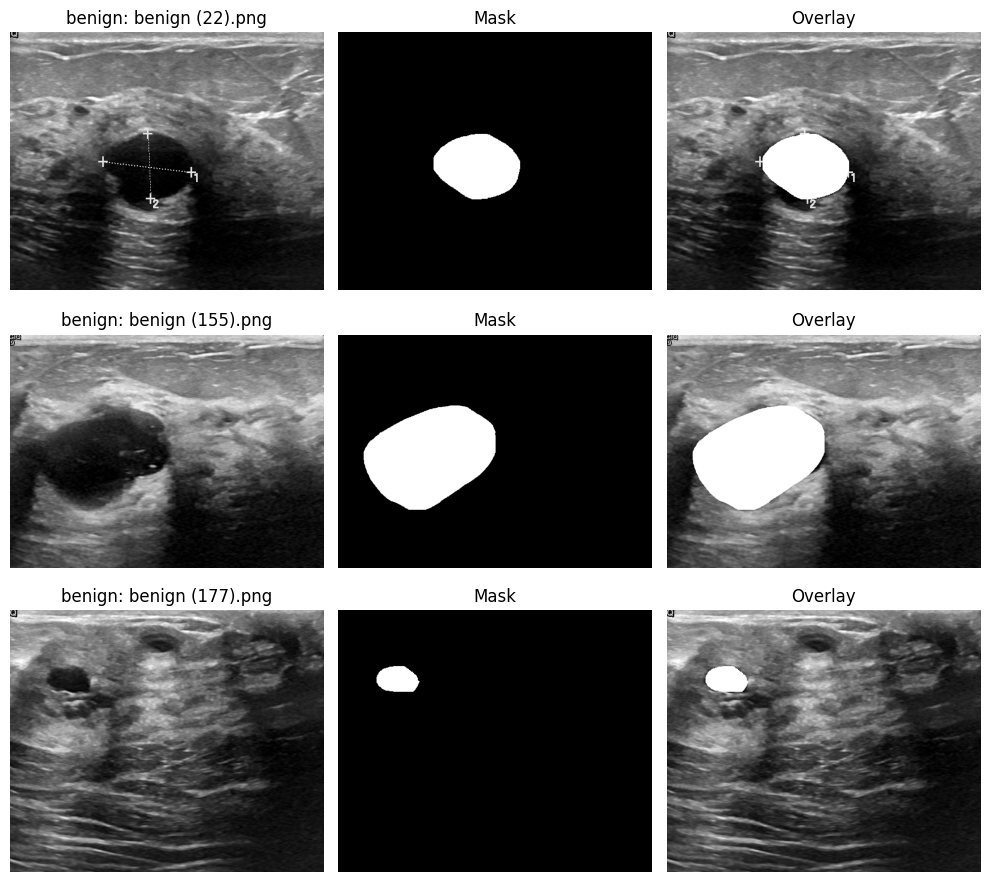

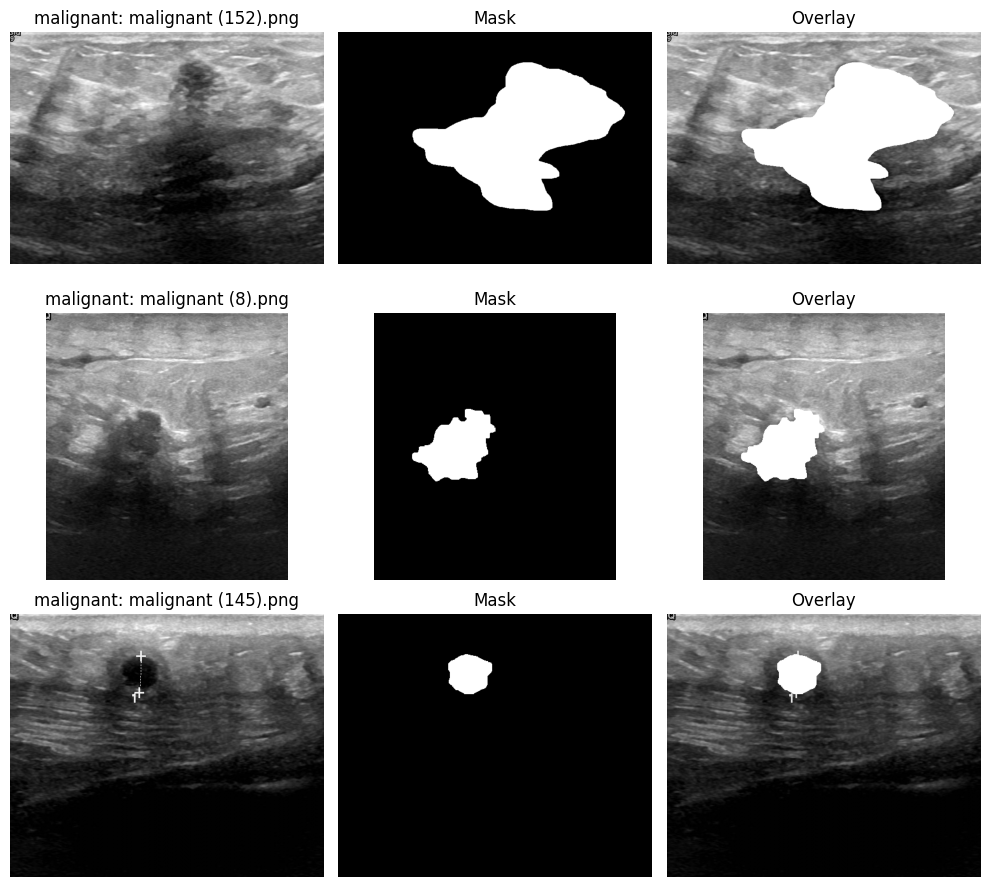


Image dimensions (first 20 samples per class):
          height                                                        width  \
           count    mean        std    min     25%    50%    75%    max count   
class                                                                           
benign      20.0  474.95  64.398002  338.0  459.25  468.0  484.0  585.0  20.0   
malignant   20.0  503.55  60.698110  393.0  464.50  479.0  575.5  603.0  20.0   

                                                                    
             mean         std    min     25%    50%     75%    max  
class                                                               
benign     595.65  104.129613  370.0  556.00  562.0  622.25  783.0  
malignant  602.50  138.626533  321.0  553.75  557.5  671.25  922.0  

Average lesion area ratio:
class
benign       0.065742
malignant    0.144801
Name: lesion_ratio, dtype: float64


In [5]:
# Visualize samples from both classes
def load_image_and_mask(img_path, mask_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    return img, mask

def plot_samples(class_name, n_samples=3):
    class_path = os.path.join(train_path, class_name)

    # Get image files (not masks)
    img_files = [f for f in os.listdir(class_path) if '_mask' not in f][:n_samples]

    fig, axes = plt.subplots(n_samples, 3, figsize=(10, n_samples*3))
    if n_samples == 1:
        axes = axes.reshape(1, -1)

    for i, img_file in enumerate(img_files):
        # Paths
        img_path = os.path.join(class_path, img_file)
        mask_path = os.path.join(class_path, img_file.replace('.png', '_mask.png'))

        # Load
        img, mask = load_image_and_mask(img_path, mask_path)

        # Show original
        axes[i, 0].imshow(img, cmap='gray')
        axes[i, 0].set_title(f'{class_name}: {img_file}')
        axes[i, 0].axis('off')

        # Show mask
        axes[i, 1].imshow(mask, cmap='gray')
        axes[i, 1].set_title('Mask')
        axes[i, 1].axis('off')

        # Show overlay
        overlay = img.copy()
        overlay[mask > 0] = 255
        axes[i, 2].imshow(overlay, cmap='gray')
        axes[i, 2].set_title('Overlay')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

# Visualize samples
plot_samples('benign', 3)
plot_samples('malignant', 3)

# Analyze image properties
def analyze_image_properties():
    stats = []

    for class_name in ['benign', 'malignant']:
        class_path = os.path.join(train_path, class_name)
        img_files = [f for f in os.listdir(class_path) if '_mask' not in f][:20]

        for img_file in img_files:
            img_path = os.path.join(class_path, img_file)
            mask_path = os.path.join(class_path, img_file.replace('.png', '_mask.png'))

            if os.path.exists(mask_path):
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

                # Calculate lesion area
                lesion_pixels = np.sum(mask > 0)
                total_pixels = mask.shape[0] * mask.shape[1]
                lesion_ratio = lesion_pixels / total_pixels

                stats.append({
                    'class': class_name,
                    'height': img.shape[0],
                    'width': img.shape[1],
                    'lesion_ratio': lesion_ratio
                })

    df = pd.DataFrame(stats)
    print("\nImage dimensions (first 20 samples per class):")
    print(df.groupby('class')[['height', 'width']].describe())
    print(f"\nAverage lesion area ratio:")
    print(df.groupby('class')['lesion_ratio'].mean())

analyze_image_properties()

In [6]:
# Data loading pipeline
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn.functional as F

class BreastUltrasoundDataset(Dataset):
    def __init__(self, root_dir, transform=None, mode='train'):
        self.root_dir = root_dir
        self.transform = transform
        self.mode = mode
        self.samples = []

        if mode == 'train':
            # Load training data
            for class_name, label in [('benign', 0), ('malignant', 1)]:
                class_path = os.path.join(root_dir, class_name)

                # Get unique studies (images without _mask)
                img_files = [f for f in os.listdir(class_path) if '_mask' not in f]

                for img_file in img_files:
                    # Find all masks for this image
                    base_name = img_file.replace('.png', '')
                    masks = []

                    # Check for primary mask
                    if os.path.exists(os.path.join(class_path, f"{base_name}_mask.png")):
                        masks.append(f"{base_name}_mask.png")

                    # Check for additional masks
                    for i in range(1, 5):  # Assume max 5 masks
                        mask_name = f"{base_name}_mask_{i}.png"
                        if os.path.exists(os.path.join(class_path, mask_name)):
                            masks.append(mask_name)

                    if masks:  # Only add if has mask
                        self.samples.append({
                            'img_path': os.path.join(class_path, img_file),
                            'mask_paths': [os.path.join(class_path, m) for m in masks],
                            'label': label,
                            'class_name': class_name
                        })

        print(f"Loaded {len(self.samples)} samples")
        if mode == 'train':
            benign_count = sum(1 for s in self.samples if s['label'] == 0)
            print(f"Class distribution: {benign_count} benign, {len(self.samples)-benign_count} malignant")

    def __len__(self):
        return len(self.samples)

    def extract_lesion_bbox(self, mask):
        # Find bounding box of lesion
        coords = np.where(mask > 0)
        if len(coords[0]) == 0:
            return None

        y_min, y_max = coords[0].min(), coords[0].max()
        x_min, x_max = coords[1].min(), coords[1].max()

        # Add padding
        pad = 20
        y_min = max(0, y_min - pad)
        x_min = max(0, x_min - pad)
        y_max = min(mask.shape[0], y_max + pad)
        x_max = min(mask.shape[1], x_max + pad)

        return (y_min, y_max, x_min, x_max)

    def __getitem__(self, idx):
        sample = self.samples[idx]

        # Load image
        img = cv2.imread(sample['img_path'], cv2.IMREAD_GRAYSCALE)

        # For multiple masks, combine them
        combined_mask = None
        for mask_path in sample['mask_paths']:
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            if combined_mask is None:
                combined_mask = mask
            else:
                combined_mask = np.maximum(combined_mask, mask)

        # Extract lesion region
        bbox = self.extract_lesion_bbox(combined_mask)
        if bbox:
            y_min, y_max, x_min, x_max = bbox
            img_crop = img[y_min:y_max, x_min:x_max]
        else:
            img_crop = img

        # Convert to RGB (pretrained models expect 3 channels)
        img_crop = cv2.cvtColor(img_crop, cv2.COLOR_GRAY2RGB)

        # Convert to PIL for transforms
        img_pil = Image.fromarray(img_crop)

        if self.transform:
            img_tensor = self.transform(img_pil)
        else:
            img_tensor = transforms.ToTensor()(img_pil)

        return img_tensor, sample['label']

# Define transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create dataset
dataset = BreastUltrasoundDataset('/content/dataset/training_set', transform=train_transform)

# Verify loading works
img, label = dataset[0]
print(f"\nSample tensor shape: {img.shape}")
print(f"Label: {label}")

Loaded 547 samples
Class distribution: 387 benign, 160 malignant

Sample tensor shape: torch.Size([3, 224, 224])
Label: 0


In [7]:
# Train/val split and data loaders
from sklearn.model_selection import train_test_split

# Get all indices and labels
all_labels = [dataset.samples[i]['label'] for i in range(len(dataset))]

# Stratified split
train_idx, val_idx = train_test_split(
    range(len(dataset)),
    test_size=0.2,
    stratify=all_labels,
    random_state=42
)

print(f"Train samples: {len(train_idx)}, Val samples: {len(val_idx)}")

# Create separate datasets for train/val
train_dataset = torch.utils.data.Subset(dataset, train_idx)
val_dataset = torch.utils.data.Subset(dataset, val_idx)

# Update transform for validation
val_dataset.dataset.transform = val_transform

# Calculate class weights for loss
train_labels = [all_labels[i] for i in train_idx]
class_counts = np.bincount(train_labels)
class_weights = len(train_labels) / (len(class_counts) * class_counts)
class_weights = torch.FloatTensor(class_weights).to(device)
print(f"Class weights: {class_weights}")

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}")

Train samples: 437, Val samples: 110
Class weights: tensor([0.7071, 1.7070], device='cuda:0')
Train batches: 14, Val batches: 4


In [8]:
# Model definition
import torch.nn as nn
from torchvision import models

class BreastCancerClassifier(nn.Module):
    def __init__(self, model_name='efficientnet_b0', num_classes=2):
        super().__init__()

        # Load pretrained model
        if model_name == 'efficientnet_b0':
            self.base_model = models.efficientnet_b0(pretrained=True)
            num_features = self.base_model.classifier[1].in_features
            # Replace classifier
            self.base_model.classifier = nn.Sequential(
                nn.Dropout(0.2),
                nn.Linear(num_features, 512),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(512, num_classes)
            )
        elif model_name == 'densenet121':
            self.base_model = models.densenet121(pretrained=True)
            num_features = self.base_model.classifier.in_features
            self.base_model.classifier = nn.Sequential(
                nn.Linear(num_features, 512),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(512, num_classes)
            )

    def forward(self, x):
        return self.base_model(x)

# Initialize model
model = BreastCancerClassifier(model_name='efficientnet_b0').to(device)
print(f"Model loaded on {device}")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 202MB/s]

Model loaded on cuda
Total parameters: 4,664,446
Trainable parameters: 4,664,446


In [9]:
# Training setup
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
import time

# Loss and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

# Training history
history = {
    'train_loss': [], 'val_loss': [],
    'train_acc': [], 'val_acc': [],
    'val_auc': [], 'val_sensitivity': [], 'val_specificity': []
}

# Training functions
def train_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    return total_loss / len(loader), 100. * correct / total

def validate_epoch(model, loader, criterion):
    model.eval()
    total_loss = 0
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            probs = torch.softmax(outputs, dim=1)
            _, predicted = outputs.max(1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())  # Prob of malignant

    # Calculate metrics
    acc = 100. * np.mean(np.array(all_labels) == np.array(all_preds))
    auc = roc_auc_score(all_labels, all_probs)

    # Confusion matrix for sensitivity/specificity
    cm = confusion_matrix(all_labels, all_preds)
    sensitivity = cm[1, 1] / (cm[1, 0] + cm[1, 1]) if (cm[1, 0] + cm[1, 1]) > 0 else 0
    specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1]) if (cm[0, 0] + cm[0, 1]) > 0 else 0

    return total_loss / len(loader), acc, auc, sensitivity, specificity, all_labels, all_preds

# Best model tracking
best_auc = 0
best_model_state = None

print("Starting training...")

Starting training...


In [10]:
# Training loop
num_epochs = 30  # Should complete in ~30-45 mins
start_time = time.time()

for epoch in range(num_epochs):
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)

    # Validate
    val_loss, val_acc, val_auc, sensitivity, specificity, val_labels, val_preds = validate_epoch(
        model, val_loader, criterion
    )

    # Update scheduler
    scheduler.step()

    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_auc'].append(val_auc)
    history['val_sensitivity'].append(sensitivity)
    history['val_specificity'].append(specificity)

    # Save best model
    if val_auc > best_auc:
        best_auc = val_auc
        best_model_state = model.state_dict().copy()

    # Print progress
    if epoch % 5 == 0:
        elapsed = (time.time() - start_time) / 60
        print(f"Epoch {epoch+1}/{num_epochs} ({elapsed:.1f} min)")
        print(f"  Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}%")
        print(f"  Val Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%, AUC: {val_auc:.4f}")
        print(f"  Sensitivity: {sensitivity:.3f}, Specificity: {specificity:.3f}")

print(f"\nTraining completed in {(time.time() - start_time)/60:.1f} minutes")
print(f"Best validation AUC: {best_auc:.4f}")

# Load best model
model.load_state_dict(best_model_state)
torch.save(best_model_state, '/content/best_breast_cancer_model.pth')
print("Best model saved!")

Epoch 1/30 (0.2 min)
  Train Loss: 0.5962, Acc: 79.63%
  Val Loss: 0.6001, Acc: 70.00%, AUC: 0.8674
  Sensitivity: 0.875, Specificity: 0.628
Epoch 6/30 (0.7 min)
  Train Loss: 0.0660, Acc: 98.86%
  Val Loss: 0.3551, Acc: 87.27%, AUC: 0.9407
  Sensitivity: 0.812, Specificity: 0.897
Epoch 11/30 (1.2 min)
  Train Loss: 0.0138, Acc: 99.77%
  Val Loss: 0.3786, Acc: 89.09%, AUC: 0.9507
  Sensitivity: 0.844, Specificity: 0.910
Epoch 16/30 (1.7 min)
  Train Loss: 0.0104, Acc: 99.77%
  Val Loss: 0.4458, Acc: 88.18%, AUC: 0.9463
  Sensitivity: 0.812, Specificity: 0.910
Epoch 21/30 (2.2 min)
  Train Loss: 0.0074, Acc: 99.77%
  Val Loss: 0.4485, Acc: 89.09%, AUC: 0.9503
  Sensitivity: 0.812, Specificity: 0.923
Epoch 26/30 (2.7 min)
  Train Loss: 0.0041, Acc: 100.00%
  Val Loss: 0.4356, Acc: 88.18%, AUC: 0.9483
  Sensitivity: 0.812, Specificity: 0.910

Training completed in 3.1 minutes
Best validation AUC: 0.9511
Best model saved!


Final Validation Performance:
AUC: 0.9467
Accuracy: 90.00%
Sensitivity (recall for malignant): 0.812
Specificity (recall for benign): 0.936


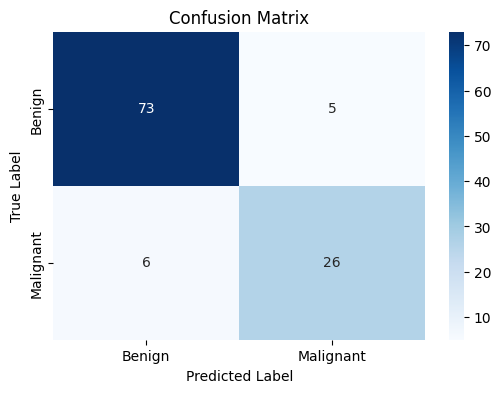


Classification Report:
              precision    recall  f1-score   support

      Benign       0.92      0.94      0.93        78
   Malignant       0.84      0.81      0.83        32

    accuracy                           0.90       110
   macro avg       0.88      0.87      0.88       110
weighted avg       0.90      0.90      0.90       110



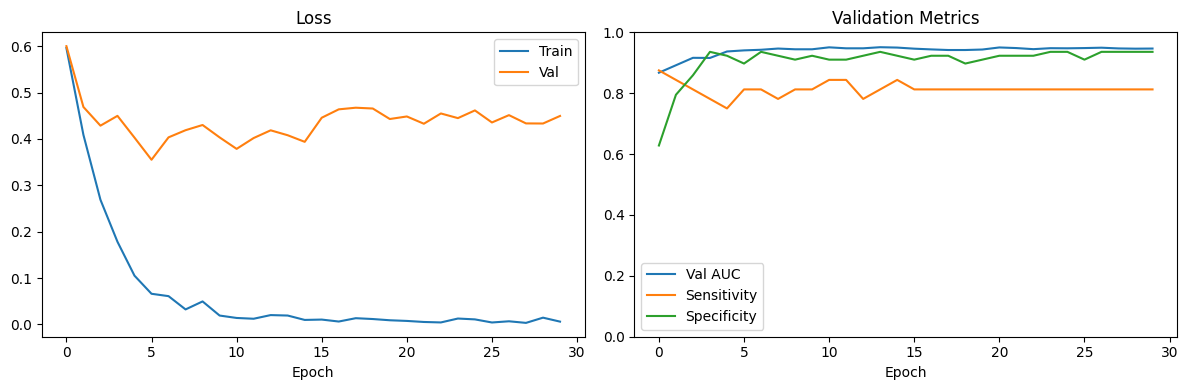

In [11]:
# Final evaluation
model.eval()
_, val_acc, val_auc, sensitivity, specificity, val_labels, val_preds = validate_epoch(
    model, val_loader, criterion
)

# Detailed results
print("Final Validation Performance:")
print(f"AUC: {val_auc:.4f}")
print(f"Accuracy: {val_acc:.2f}%")
print(f"Sensitivity (recall for malignant): {sensitivity:.3f}")
print(f"Specificity (recall for benign): {specificity:.3f}")

# Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(val_labels, val_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Benign', 'Malignant'],
            yticklabels=['Benign', 'Malignant'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(val_labels, val_preds,
                          target_names=['Benign', 'Malignant']))

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Loss
axes[0].plot(history['train_loss'], label='Train')
axes[0].plot(history['val_loss'], label='Val')
axes[0].set_title('Loss')
axes[0].set_xlabel('Epoch')
axes[0].legend()

# AUC
axes[1].plot(history['val_auc'], label='Val AUC')
axes[1].plot(history['val_sensitivity'], label='Sensitivity')
axes[1].plot(history['val_specificity'], label='Specificity')
axes[1].set_title('Validation Metrics')
axes[1].set_xlabel('Epoch')
axes[1].legend()
axes[1].set_ylim([0, 1])

plt.tight_layout()
plt.show()

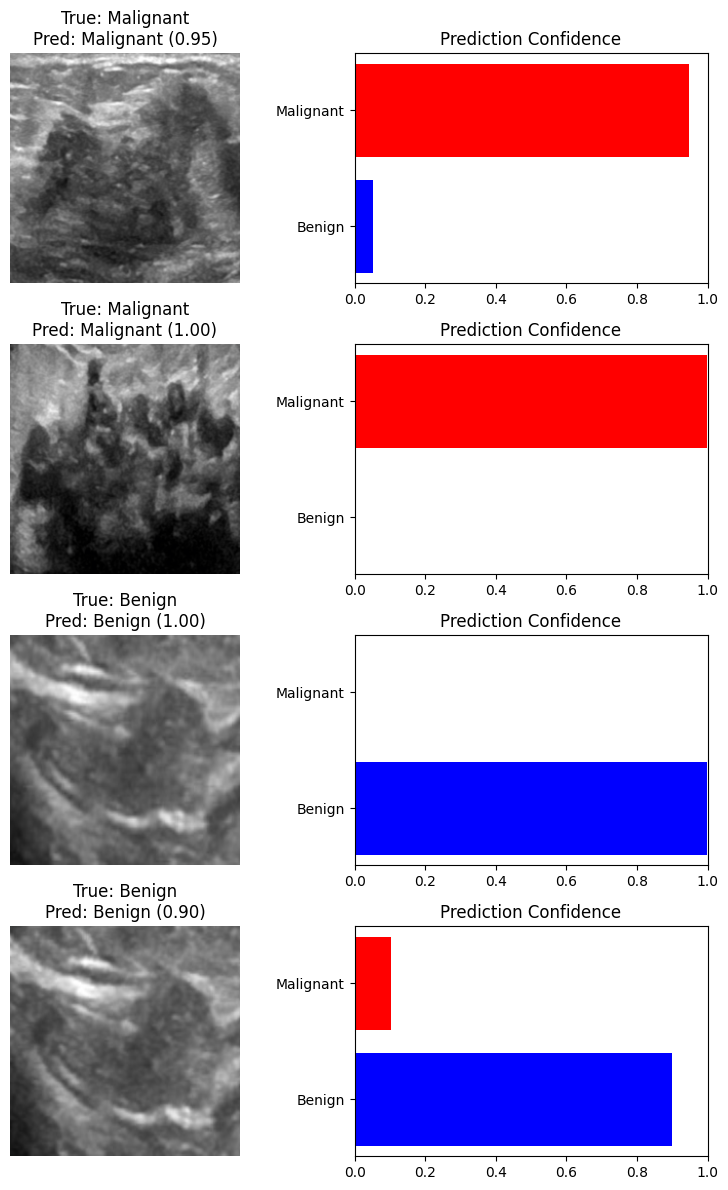

Grad-CAM initialized successfully


In [12]:
# Fixed Grad-CAM implementation
import torch.nn.functional as F

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Register hooks
        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_full_backward_hook(self.save_gradient)  # Fixed: use full_backward_hook

    def save_activation(self, module, input, output):
        self.activations = output.detach()  # Fixed: detach

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()  # Fixed: detach

    def generate_cam(self, input_image, target_class):
        # Forward pass
        model_output = self.model(input_image)
        self.model.zero_grad()

        # Backward pass
        one_hot = torch.zeros_like(model_output)
        one_hot[0][target_class] = 1
        model_output.backward(gradient=one_hot, retain_graph=True)

        # Generate CAM
        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        activations = self.activations.clone()
        for i in range(activations.shape[1]):
            activations[:, i, :, :] *= pooled_gradients[i]

        cam = torch.mean(activations, dim=1).squeeze()
        cam = F.relu(cam)
        cam = cam / torch.max(cam)

        return cam.detach().cpu().numpy()  # Fixed: detach before numpy

# Simplified visualization
def visualize_predictions_simple(model, dataset, num_samples=4):
    model.eval()
    fig, axes = plt.subplots(num_samples, 2, figsize=(8, num_samples*3))
    if num_samples == 1:
        axes = axes.reshape(1, -1)

    # Get random samples
    indices = np.random.choice(len(dataset), num_samples, replace=False)

    for i, idx in enumerate(indices):
        img_tensor, true_label = dataset[idx]
        img_tensor = img_tensor.unsqueeze(0).to(device)

        # Get prediction
        with torch.no_grad():
            output = model(img_tensor)
            probs = torch.softmax(output, dim=1)
            pred_label = output.argmax(1).item()
            confidence = probs[0, pred_label].item()

        # Get original image (denormalize)
        img_np = img_tensor.cpu().squeeze().permute(1, 2, 0).numpy()
        img_np = img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img_np = np.clip(img_np, 0, 1)

        # Plot
        axes[i, 0].imshow(img_np)
        axes[i, 0].set_title(f'True: {["Benign", "Malignant"][true_label]}\n'
                           f'Pred: {["Benign", "Malignant"][pred_label]} ({confidence:.2f})')
        axes[i, 0].axis('off')

        # Confidence bars
        axes[i, 1].barh(['Benign', 'Malignant'], probs[0].cpu().numpy(),
                       color=['blue', 'red'])
        axes[i, 1].set_xlim([0, 1])
        axes[i, 1].set_title('Prediction Confidence')

    plt.tight_layout()
    plt.show()

# Run simplified visualization first
visualize_predictions_simple(model, val_dataset, num_samples=4)

# Try Grad-CAM with the fixed version
try:
    target_layer = model.base_model.features[-1]
    grad_cam = GradCAM(model, target_layer)
    print("Grad-CAM initialized successfully")
except Exception as e:
    print(f"Grad-CAM initialization failed: {e}")

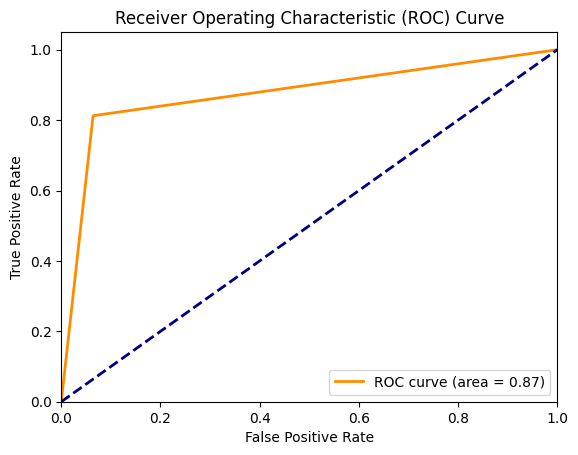

In [14]:
# Re-run validation to get all_probs
model.eval()
val_loss, val_acc, val_auc, sensitivity, specificity, val_labels, all_probs = validate_epoch(
    model, val_loader, criterion
)

# Plot ROC curve
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(val_labels, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()